In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 990 kB 18.4 MB/s 


In [ ]:
import os
import glob
path='/content/drive/MyDrive/autopet'
pathct=glob.glob(os.path.join(path,'*','*','*CTres.nii.gz'))
pathpet=glob.glob(os.path.join(path,'*','*','*SUV.nii.gz'))
pathseg=glob.glob(os.path.join(path,'*','*','*SEG.nii.gz'))

In [ ]:
data_train= [{"ct": ct, "pet": pet, "label": label_name}
             for ct, pet,  label_name in zip(pathct, pathpet, pathseg)
             ]

In [ ]:
data_train[0]

{'ct': '/content/drive/MyDrive/autopet/PETCT_0af7ffe12a/08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-96698/CTres.nii.gz',
 'pet': '/content/drive/MyDrive/autopet/PETCT_0af7ffe12a/08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-96698/SUV.nii.gz',
 'label': '/content/drive/MyDrive/autopet/PETCT_0af7ffe12a/08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-96698/SEG.nii.gz'}

In [ ]:
from monai.data import (
    Dataset,
    DatasetSummary,
    load_decathlon_datalist,
    load_decathlon_properties,
)
train_files=[{'image':image_name,'label':label_name} for image_name, label_name in zip(pathct, pathseg)]
dataset = Dataset(data=train_files,transform=LoadImaged(keys=["image", "label"]),)

#LoadImaged(keys=["vol", "seg"])
#train_ds = Dataset(data=train_files)
#data_loader = DataLoader(dataset=train_ds, batch_size=1, num_workers=0)

#train_loader = DataLoader(train_ds, batch_size=1)
calculator = DatasetSummary(dataset)
target_spacing = calculator.get_target_spacing()
print("spacing: ", target_spacing)
#this function also prints the mean and std values (used for normalization), 
calculator.calculate_statistics()
print("mean: ", calculator.data_mean, " std: ", calculator.data_std)
#the min (0.5 percentile) and max(99.5 percentile) values (used for clip).
calculator.calculate_percentiles(sampling_flag=True, interval=10, min_percentile=0.5, max_percentile=99.5)
print("min: ",calculator.data_min_percentile," max: ",calculator.data_max_percentile,)
#spacing:  (2.0364201068878174, 2.0364201068878174, 3.0)

spacing:  (2.0364201068878174, 2.0364201068878174, 3.0)


RuntimeError: ignored

In [ ]:
import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    Spacingd,
    Orientationd,
    SpatialPadd,
    NormalizeIntensityd,
    RandSpatialCropd,
    RandRotated,
    RandZoomd,
    CastToTyped,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandFlipd,
    ToTensord,
)
from monai.transforms import MapTransform
image_keys=["ct", "pet", ]
all_keys=["ct", "pet", "label"]
train_transform = Compose([
    LoadImaged(keys=all_keys),
    AddChanneld(keys=all_keys),
    #ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
    # Crop based on thresholding > 0 in source_key
    CropForegroundd(keys=all_keys, source_key=image_keys[0]),
    Spacingd(keys=all_keys,pixdim=(2.0,2.0,2.0),
             mode=("bilinear",) * len(image_keys) + ("nearest",),
             ),
    #TO change orientation for the default orientation used in BraTS
    Orientationd(keys=all_keys, axcodes="RAS"),
    SpatialPadd(keys=all_keys, spatial_size=(128, 128, 128)),
    #TOD is the zoom ratio computed for each dimension independently?
    RandZoomd(keys=all_keys,
              min_zoom=0.7,
              max_zoom=1.5,
              mode=("trilinear",) * len(image_keys) + ("nearest",),
              align_corners=(True,) * len(image_keys) + (None,),
              prob=0.3,),
    RandRotated(keys=all_keys,
                range_x=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
                range_y=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
                range_z=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
                mode=("bilinear",) * len(image_keys) + ("nearest",),
                align_corners=(True,) * len(image_keys) + (None,),
                padding_mode=("border", ) * len(all_keys),
                prob=0.3,),
    # Return a batch of spatial size equal to roi_size
    # that is strictly contained inside the input batch.
    # The position of the output batch is selected randomly (random_center=True).
    # I suppose it si better to do the random crop after the zoom and rotation.
    RandSpatialCropd(keys=all_keys,
                     roi_size=(128, 128, 128),
                     random_center=True,
                     random_size=False,),
    RandGaussianNoised(keys=image_keys, mean=0., std=0.1, prob=0.2),
    RandGaussianSmoothd(keys=image_keys,
                        sigma_x=(0.5, 1.15),
                        sigma_y=(0.5, 1.15),
                        sigma_z=(0.5, 1.15),
                        prob=0.2,),
    RandAdjustContrastd(keys=image_keys,
                        gamma=(0.7, 1.5),
                        prob=0.3,),
    # RandFlipd(all_keys, spatial_axis=[0, 1, 2], prob=0.5),
    RandFlipd(all_keys, spatial_axis=[0], prob=0.5),  # Only right-left flip
    # if we put NormalizeIntensityd at the end, it solves validation dice oscillation
    NormalizeIntensityd(keys=image_keys, nonzero=True, channel_wise=True),
    CastToTyped(keys=all_keys, dtype=(np.float32,) * len(image_keys) + (np.uint8,)),
    ToTensord(keys=all_keys),])


val_transform = Compose([
    LoadImaged(keys=all_keys),
    AddChanneld(keys=all_keys),
    #ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
    CropForegroundd(keys=all_keys, source_key=image_keys[0]),
    Spacingd(keys=all_keys,
             pixdim=(2.0,2.0,2.0),
              mode=("bilinear",) * len(image_keys) + ("nearest",),
              ),
    Orientationd(keys=all_keys, axcodes="RAS"),
    SpatialPadd(keys=all_keys, spatial_size=(128,128,128)),
    NormalizeIntensityd(keys=image_keys, nonzero=False, channel_wise=True),
    CastToTyped(keys=all_keys, dtype=(np.float32,) * len(image_keys) + (np.uint8,)),
    ToTensord(keys=all_keys),
    ])

In [ ]:
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
set_determinism(seed=0)
from monai.utils import first
my_transform_org=Compose([LoadImaged(keys=all_keys),AddChanneld(keys=all_keys),ToTensord(keys=all_keys)])
from monai.data import PersistentDataset, Dataset
generat_ds = Dataset(data=data_train, transform=train_transform)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

original_ds = Dataset(data=data_train, transform=my_transform_org)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

In [ ]:
label_key = 'label'
def get_batch(batchdata):
        return tuple([batchdata[key] for key in image_keys]), batchdata[label_key]
import torch
my_transform_org=Compose([LoadImaged(keys=all_keys),AddChanneld(keys=all_keys),ToTensord(keys=all_keys)])
original_ds = Dataset(data=data_train, transform=my_transform_org)
original_loader = DataLoader(original_ds, batch_size=1)
for i,d in enumerate(original_loader):
  imges,label_o=get_batch(d)
  #print(d['flair'].shape)
  #print(d['label'].shape)
  inputs = torch.cat(imges, 1)
  print(inputs.shape)
  print(label_o.shape)
  break

for i,d in enumerate(generat_loader):
  imges,label_g=get_batch(d)
  #print(d['flair'].shape)
  #print(d['label'].shape)
  inputsg = torch.cat(imges, 1)
  print(inputsg.shape)
  print(label_g.shape)
  break

torch.Size([1, 2, 400, 400, 304])
torch.Size([1, 1, 400, 400, 304])
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


In [ ]:
import numpy as np
for i in range(0,len(label_o[0, 0, :, :,:])):
  print(i)
  print(np.unique(label_o[0, 0, :, :,i]))
  #print(i)

0
[0.]
1
[0.]
2
[0.]
3
[0.]
4
[0.]
5
[0.]
6
[0.]
7
[0.]
8
[0.]
9
[0.]
10
[0.]
11
[0.]
12
[0.]
13
[0.]
14
[0.]
15
[0.]
16
[0.]
17
[0.]
18
[0.]
19
[0.]
20
[0.]
21
[0.]
22
[0.]
23
[0.]
24
[0.]
25
[0.]
26
[0.]
27
[0.]
28
[0.]
29
[0.]
30
[0.]
31
[0.]
32
[0.]
33
[0.]
34
[0.]
35
[0.]
36
[0.]
37
[0.]
38
[0.]
39
[0.]
40
[0.]
41
[0.]
42
[0.]
43
[0.]
44
[0.]
45
[0.]
46
[0.]
47
[0.]
48
[0.]
49
[0.]
50
[0.]
51
[0.]
52
[0.]
53
[0.]
54
[0.]
55
[0.]
56
[0.]
57
[0.]
58
[0.]
59
[0.]
60
[0.]
61
[0.]
62
[0.]
63
[0.]
64
[0.]
65
[0.]
66
[0.]
67
[0.]
68
[0.]
69
[0.]
70
[0.]
71
[0.]
72
[0.]
73
[0.]
74
[0.]
75
[0.]
76
[0.]
77
[0.]
78
[0.]
79
[0.]
80
[0.]
81
[0.]
82
[0.]
83
[0.]
84
[0.]
85
[0.]
86
[0.]
87
[0.]
88
[0.]
89
[0.]
90
[0.]
91
[0.]
92
[0.]
93
[0.]
94
[0.]
95
[0.]
96
[0.]
97
[0.]
98
[0.]
99
[0.]
100
[0.]
101
[0.]
102
[0.]
103
[0.]
104
[0.]
105
[0.]
106
[0.]
107
[0.]
108
[0.]
109
[0.]
110
[0.]
111
[0.]
112
[0.]
113
[0.]
114
[0.]
115
[0.]
116
[0.]
117
[0.]
118
[0.]
119
[0.]
120
[0.]
121
[0.]
122
[0.]
123

IndexError: ignored

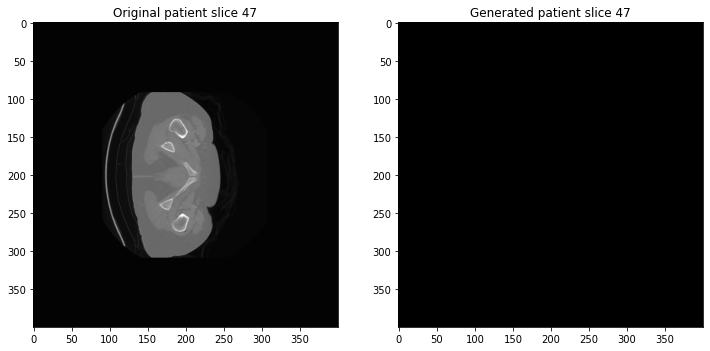

In [ ]:
import matplotlib.pyplot as plt
number_slice = 47
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(inputs[0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(label_o[0, 0, :, :, number_slice], cmap="gray")

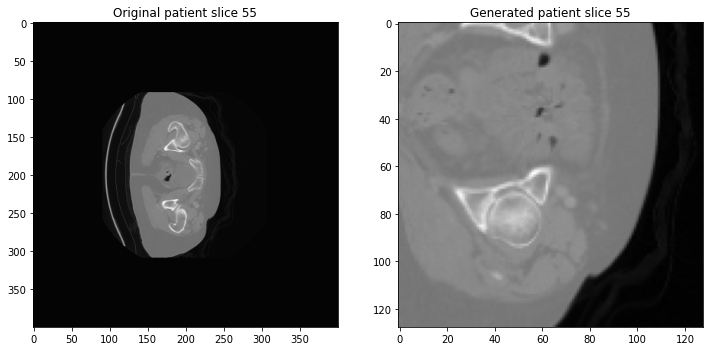

In [ ]:
import matplotlib.pyplot as plt
number_slice = 55
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["ct"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["ct"][0, 0, :, :, number_slice], cmap="gray")

torch.Size([1, 1, 400, 400, 304])


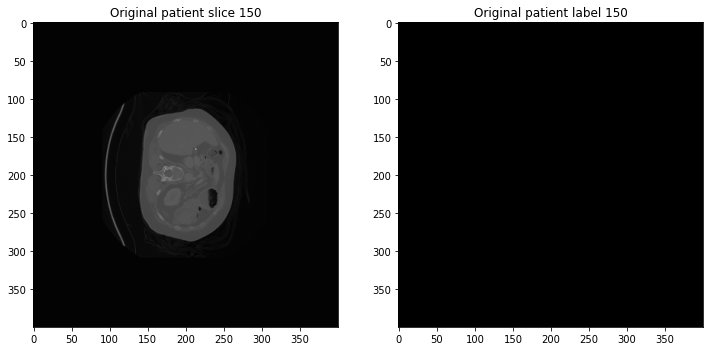

In [ ]:
import matplotlib.pyplot as plt
number_slice = 150
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["ct"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Original patient label {number_slice}")
plt.imshow(original_patient["label"][0, 0, :, :, number_slice], cmap="gray")
print(original_patient["ct"].shape)